Epoch 1/5 (Validation): 100%|██████████| 2/2 [00:01<00:00,  1.17it/s]


Epoch 1/5 - Train Loss: 11.3168 | Validation Loss: 7.7788 | Validation Accuracy: 12.00%


Epoch 2/5 (Validation): 100%|██████████| 2/2 [00:01<00:00,  1.64it/s]


Epoch 2/5 - Train Loss: 5.2440 | Validation Loss: 2.4968 | Validation Accuracy: 10.00%


Epoch 3/5 (Validation): 100%|██████████| 2/2 [00:01<00:00,  1.64it/s]


Epoch 3/5 - Train Loss: 2.4818 | Validation Loss: 2.3462 | Validation Accuracy: 10.00%


Epoch 4/5 (Validation): 100%|██████████| 2/2 [00:01<00:00,  1.65it/s]


Epoch 4/5 - Train Loss: 2.2296 | Validation Loss: 2.3116 | Validation Accuracy: 8.00%


Epoch 5/5 (Validation): 100%|██████████| 2/2 [00:01<00:00,  1.75it/s]


Epoch 5/5 - Train Loss: 2.1253 | Validation Loss: 2.3252 | Validation Accuracy: 6.00%

--- Task 10 Results ---
Total predictions collected: 50
Total ground truth labels collected: 50
Example Predictions: [np.int64(4), np.int64(4), np.int64(0), np.int64(4), np.int64(4), np.int64(0), np.int64(0), np.int64(4), np.int64(4), np.int64(4)]
Example Labels: [np.int64(5), np.int64(0), np.int64(8), np.int64(0), np.int64(5), np.int64(6), np.int64(3), np.int64(2), np.int64(8), np.int64(1)]


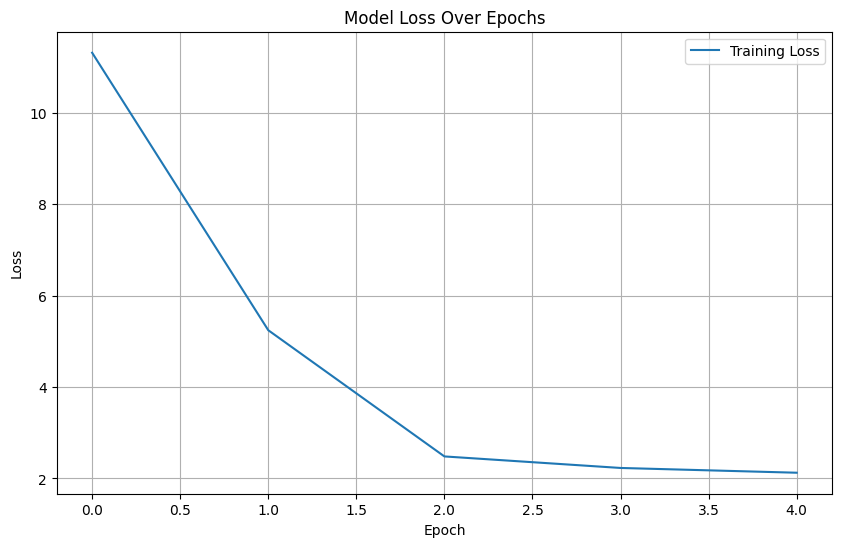

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt


class DummyDataset(Dataset):
    def __init__(self, num_samples=100, num_classes=10):
        self.samples = torch.randn(num_samples, 3, 224, 224)
        self.labels = torch.randint(0, num_classes, (num_samples,))

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.samples[idx], self.labels[idx]


class SimpleClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleClassifier, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 56 * 56, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


train_dataset = DummyDataset()
val_dataset = DummyDataset(num_samples=50)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


model = SimpleClassifier(num_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


training_loss_history = []

epochs = 5
for epoch in range(epochs):
    # Reset variables for each epoch (as per Task 6)
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    model.train()
    # Use tqdm to create a progress bar (as per Question 5)
    train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} (Training)")
    for inputs, labels in train_loop:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()


    avg_train_loss = train_loss / train_total
    training_loss_history.append(avg_train_loss)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0


    with torch.no_grad():
        val_loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} (Validation)")
        for inputs, labels in val_loop:
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / val_total
    val_accuracy = val_correct / val_total

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} | Validation Loss: {avg_val_loss:.4f} | Validation Accuracy: {val_accuracy*100:.2f}%")



all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        # Append predictions and labels to the lists
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("\n--- Task 10 Results ---")
print(f"Total predictions collected: {len(all_preds)}")
print(f"Total ground truth labels collected: {len(all_labels)}")
print("Example Predictions:", all_preds[:10])
print("Example Labels:", all_labels[:10])



plt.figure(figsize=(10, 6))
plt.plot(training_loss_history, label='Training Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()